### Comprehensive RBR vs SBE CTD Comparison on AQ1801

In [1185]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import (YearLocator, WeekdayLocator, MonthLocator, 
                            MinuteLocator, DayLocator, HourLocator, DateFormatter)
import matplotlib.ticker as ticker

import cmocean

In [1186]:
### specify primary bulk figure parameters
fontsize = 10
labelsize = 10
#plotstyle = 'seaborn'
max_xticks = 10
plt.style.use('seaborn-ticks')
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['ps.fonttype'] = 42 #truetype/type2 fonts instead of type3
mpl.rcParams['pdf.fonttype'] = 42 #truetype/type2 fonts instead of type3
mpl.rcParams['axes.grid'] = False
mpl.rcParams['axes.edgecolor'] = 'black'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.labelcolor'] = 'black'
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['xtick.major.size'] = 4
mpl.rcParams['xtick.minor.size'] = 2
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['xtick.minor.width'] = 0.5
mpl.rcParams['ytick.major.size'] = 4
mpl.rcParams['ytick.minor.size'] = 2
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['ytick.minor.width'] = 0.5
mpl.rcParams['ytick.direction'] = 'out'
mpl.rcParams['xtick.direction'] = 'out'
mpl.rcParams['ytick.color'] = 'black'
mpl.rcParams['xtick.color'] = 'black'

In [1187]:
import pandas as pd
import datetime
import numpy as np

#### Cast 025
**Location: ** 

__Notes:__ 
__Programming Notes:__ .rsk file is a SQLite3 file and it appears that all conductivity-temperature corrections are done prior to recording conductivity values.  Can read straight from file instead of converting with RBR software

__Processing Notes:__ .hex seabird files are converted to .cnv files as per usual processing (all seabird routines run).  .rsk files are not adjusted at all, but the salinity is calculated from the Temp/Cond/Press values as it is not in the raw data file.

In [1188]:
import sqlite3
import seawater

In [1189]:
data_file = '/Users/bell/ecoraid/2018/CTDcasts/AQ1801/raw/2018_aquila_rbr/AQ1801cast025.rsk'
db = sqlite3.connect(data_file)

query = 'SELECT * FROM channels'
columns = pd.read_sql_query(query,db)

In [1190]:
query = 'SELECT * FROM data'

df_r = pd.read_sql_query(query,db)

In [1191]:
#time in rbr file is msec since 1970-1-1
import cftime #replaces import from netCDF4 date2num
df_r['cfdatetime'] = cftime.num2date(df_r['tstamp'],'milliseconds since 1970-1-1') - datetime.timedelta(seconds=1.75)
df_r.set_index(df_r['cfdatetime'],inplace=True)

In [1192]:
#Using TEOS-10 calculations for salinity from conductivity, temperature, pressure
df_r['conductivity'] = df_r.channel01
df_r['temperature'] = df_r.channel02
df_r['pressure'] = df_r.channel03 - 10.75 #subtract standard atmosphere + an arbitrary offset? due to matching features up on seabird, may be due to offset on sbe? 
                                          # see 2019 cruises on dyson (although this was an AQ cruise)

df_r['salinity'] = seawater.salt(r=df_r['conductivity']/42.914,t=df_r['temperature'],p=df_r['pressure'])

/Users/bell/anaconda2/envs/py37/lib/python3.7/site-packages/seawater/library.py:363: RuntimeWarning: invalid value encountered in sqrt
  Rtx = (rt) ** 0.5


**For comprehensive analysis, one should follow Processing Notes Provided by RBR**

Summary of Steps:
1. Determine and subtract atmospheric pressure from total pressure
    - already taken care of but... odd bias, not exactly removing STP
1. Interpolate over first-order holds
    ```matlab
    %% Correct for A2D zero-order hold
    % The analog-to-digital (A2D) converter on RBR instruments must
    % recalibrate periodically.  In the time it takes for the calibration
    % to finish, one or more samples are missed.  The onboard firmware
    % fills the missed scan with the same data measured during the
    % previous scan, a technique called a zero-order hold.
    %
    % The function identifies zero-hold points by looking for where
    % consecutive differences for each channel are equal to zero, and
    % replaces these samples with a NaN or an interpolated value. See
    % <https://docs.rbr-global.com/rsktools RSKtools on-line user manual>
    % for further information.

    rsk = RSKcorrecthold(rsk,'action','interp'); 
    
    ```   
1. Smooth temperature and conductivity with a running 5 sample mean
    ```matlab
    %% Low-pass filtering
    % Low-pass filtering is commonly used to reduce noise and to match
    % sensor time constants.  Applying a low pass filter to temperature
    % and conductivity smooths high frequency variability and compensates
    % for differences in sensor time constants.  Users may also wish to
    % smooth other channels to reduce noise (e.g., optical channels such
    % as chlorophyll).
    %
    % Most RBR instruments designed for profiling (branded as _|fast_) are
    % equipped with thermistors that have a time constant of 100 msec,
    % which is slower than the conductivity cell.  When the time constants
    % are different, salinity will contain spikes at strong gradients.
    % The solution is to "slow down" the conductivity sensor to match the
    % thermistor.  In this example data set, the logger sampled at 6 Hz
    % (found using |readsamplingperiod(rsk)|), so a 5 sample running
    % average provides more than sufficient smoothing, and also reduces
    % noise.
    %
    % Note: All functions that alter the data have an optional input
    % called |'visualize'| that, when activated, plots data before and
    % after applying the function.  Users specify which profile(s) to
    % visualize.

    rsk = RSKsmooth(rsk,{'temperature','conductivity'}, 'windowLength', 5);
    ```
1. Lag conductivity by 1 sample
1. Derive salinity, depth, and profiling speed
1. Remove data occurring when profiling speed falls below 0.4 m/s, and when the CTD reverses from ship heave ("loops")
    - FOCI runs at 30m/min or even 15m/min (.5m/s or .25m/s) so lets set this threshold to .2m/s
1. Average all data in to 1dbar bins

RBR's Matlab toolbox can do this and should be used as algorithm references.   
and is the reference for the utilities below

In [1193]:
### definitions to follow steps above
def RSKcorrecthold(df_rsk,channel='channel02', action='nan'):
    if action in ['nan']:
        print(len(df_rsk[channel][df_rsk[channel].diff() == 0]))
        df_rsk[channel][df_rsk[channel].diff() == 0] = np.nan
        print("nan fill")
    elif action in ['linear']:
        print(len(df_rsk[channel][df_rsk[channel].diff() == 0]))
        df_rsk[df_rsk[channel].diff() == 0] = np.nan
        df_rsk = df_rsk.interpolate(method ='linear')
        print("linear fill")
    else:
        print("not a defined action")
    return(df_rsk)

def RSKsmooth(df_rsk, parameter='temperature',windowLength=5,method='boxcar'):
    if method in ['boxcar']:
        df_ret = df_rsk[parameter].rolling(window=windowLength).mean()
    elif method in ['median']:
        df_ret = df_rsk[parameter].rolling(window=windowLength).median()
    else:
        print("not a defined action - try boxcar or median")
    return(df_ret)




In [1194]:
df_r=RSKcorrecthold(df_r.copy(), channel='channel01', action='linear')
df_r=RSKcorrecthold(df_r.copy(), channel='channel02', action='linear')
df_r=RSKcorrecthold(df_r.copy(), channel='channel03', action='linear')
        
df_r['conductivity'] = RSKsmooth(df_r.copy(),parameter='conductivity',method='boxcar',windowLength=5)
df_r['temperature'] = RSKsmooth(df_r.copy(),parameter='temperature',method='boxcar',windowLength=5)
        
#lag conductivity by one sample
df_r.index = df_r.index + datetime.timedelta(seconds=0.125)

df_r['salinity'] = seawater.salt(r=df_r['conductivity']/42.914,t=df_r['temperature'],p=df_r['pressure'])

50
linear fill
275
linear fill
10
linear fill


In [1195]:
#calculated descent speed... estimate with deltap/deltat for m/s so 1dbar/s is 1m/s
df_r['descentspeed'] = df_r.pressure.diff()/(df_r.tstamp.diff()/1000)

# drop rows with speed less then threshold value... 0.1db/s
speed_threshold = 0.4
df_r[df_r['descentspeed'] < speed_threshold] = np.nan

#find index of max depth
bottom_index = df_r.pressure.idxmax()
soak_stop_index = datetime.datetime(2018,10,11,5,40)

# average into bins by depth
# downcast only (max depth) skipping soak
bins = np.arange(0,100,1)
df_r_binned = df_r[soak_stop_index:bottom_index].groupby(pd.cut(df_r['pressure'][soak_stop_index:bottom_index],bins=bins)).mean()

## Ingest and compare against Seabird Data

In [1196]:
colnames = ['c0mS/cm','c1mS/cm','flECO-AFL','sbeox0V','t090C','t190C','timeS','prDM','sbeox1V','par','turbWETntu0','prDM','sal00','sal11','flag']
df_sbe = pd.read_csv('/Users/bell/ecoraid/2018/CTDcasts/AQ1801/raw/CTD/datcnv_only/ctd025.cnv',skiprows=296,names=colnames,delimiter='\s+')

#start_time
df_sbe['DateTime']=[datetime.datetime.strptime('Oct 11 2018  05:39:51','%b %d %Y %H:%M:%S')+datetime.timedelta(seconds=y['timeS']) for x,y in df_sbe.iterrows()]
df_sbe.set_index(df_sbe['DateTime'],inplace=True)

/Users/bell/anaconda2/envs/py37/lib/python3.7/site-packages/pandas/io/parsers.py:702: UserWarning: Duplicate names specified. This will raise an error in the future.
  return _read(filepath_or_buffer, kwds)


In [1197]:
df_sbe.head()

,c0mS/cm,c1mS/cm,flECO-AFL,sbeox0V,t090C,t190C,timeS,prDM,sbeox1V,par,turbWETntu0,prDM.1,sal00,sal11,flag,DateTime
DateTime,,,,,,,,,,,,,,,,
2018-10-11 05:39:51.000,34.604259,34.602752,2.3891,2.5311,9.1130,9.1141,0.000,2.322,2.4579,1.7814,0.3746,2.322,32.2429,32.2403,0.0,2018-10-11 05:39:51.000
2018-10-11 05:39:51.042,34.604643,34.602431,2.3891,2.5299,9.1128,9.1144,0.042,2.308,2.4579,1.7948,0.3258,2.308,32.2434,32.2397,0.0,2018-10-11 05:39:51.042
2018-10-11 05:39:51.083,34.603939,34.602431,2.3891,2.5299,9.1133,9.1148,0.083,2.273,2.4567,1.8117,0.3258,2.273,32.2423,32.2394,0.0,2018-10-11 05:39:51.083
2018-10-11 05:39:51.125,34.604131,34.602752,2.3891,2.5311,9.1126,9.1146,0.125,2.322,2.4567,1.8324,0.3258,2.322,32.2431,32.2398,0.0,2018-10-11 05:39:51.125
2018-10-11 05:39:51.167,34.604323,34.603073,2.3891,2.5311,9.1133,9.1146,0.167,2.273,2.4567,1.8569,0.3746,2.273,32.2427,32.2402,0.0,2018-10-11 05:39:51.167


In [1198]:
df_r.head()

,tstamp,channel01,channel02,channel03,channel04,channel05,channel06,channel07,channel08,channel09,cfdatetime,conductivity,temperature,pressure,salinity,descentspeed
cfdatetime,,,,,,,,,,,,,,,,
2018-10-11 05:30:54.375,1.539236e+12,0.00399,8.706055,9.933628,-0.198873,-0.197651,0.005913,1442.063965,5.792885,8.579163,2018-10-11 05:30:54.250,NaN,NaN,-0.816372,NaN,NaN
2018-10-11 05:30:54.500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN
2018-10-11 05:30:54.625,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN
2018-10-11 05:30:54.750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN
2018-10-11 05:30:54.875,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN


There appears to be a 1.75 second offset between the actual RBR time by matching up the bottle holds.

**Goal is to match up features in the profiles both in depth and in time**.  
Now - if you compare this to depth profiles below: there is a half meter difference in features.  This is not due to the clock, this is due to the removal of the weight of the atmosphere by assuming a standard atmsophere 10.1325.  I've pulled deck data from earlier in the timeseries to use as the atmsopheric pressure - 9.919 dBar - however, to compare to the SBE - one would need to know what atmospheric pressure they removed.  In this case the total ATM pressure correction to the RBR to match features is ~10.6 (based on just making manual adjustments).  ___RBR has a pressure corrected field in their output.  Should see how they determine the value___

Additional factor may be slight deviation in sighting/location of instrumentation (aka a small lag due to vertical differences although G.Lebon. did his best to minimize this)

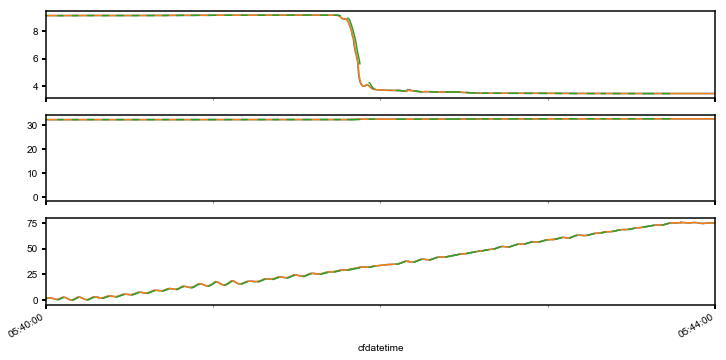

In [1199]:
tlim = [datetime.datetime(2018,10,11,5,40),datetime.datetime(2018,10,11,5,44)]

fig1 = plt.figure(figsize=(12,6))
plt.subplot(3,1,1)
df_sbe['t090C'].plot()
df_sbe['t190C'].plot()
df_r['temperature'].plot()
plt.xlim(tlim)
#plt.ylim([3.3,3.9])
ax=plt.gca()
ax.xaxis.set_major_locator(MinuteLocator([0,15,30,45]))
ax.xaxis.set_minor_locator(MinuteLocator(range(0,60)))
ax.xaxis.set_major_formatter(DateFormatter(''))
plt.xlabel('')

plt.subplot(3,1,2)
df_sbe['sal00'].plot()
df_sbe['sal11'].plot()
df_r['salinity'].plot()
plt.xlim(tlim)
#plt.ylim([32,df_t.max()])
ax=plt.gca()
ax.xaxis.set_major_locator(MinuteLocator([0,15,30,45]))
ax.xaxis.set_minor_locator(MinuteLocator(range(0,60)))
ax.xaxis.set_major_formatter(DateFormatter(''))
plt.xlabel('')

plt.subplot(3,1,3)
df_sbe['prDM'].plot()
df_sbe['prDM'].plot()
df_r['pressure'].plot()
plt.xlim(tlim)
#plt.ylim([73,75.1])
ax=plt.gca()

ax.xaxis.set_major_locator(MinuteLocator([0,15,30,45]))
ax.xaxis.set_minor_locator(MinuteLocator(range(0,60)))
ax.xaxis.set_minor_formatter(DateFormatter(''))
ax.xaxis.set_major_formatter(DateFormatter('%H:%M:%S'))
#ax.xaxis.set_tick_params(which='major', pad=15)
ax.xaxis.set_tick_params(which='minor', pad=5)

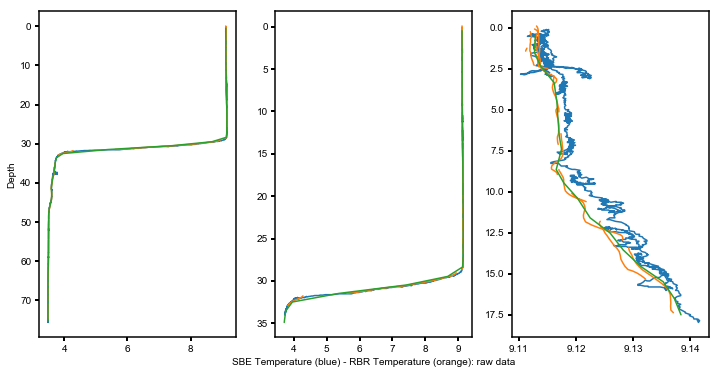

In [1214]:
start_time = '2018-10-11 05:40:00' 
end_time = '2018-10-11 05:44:00'

fig1 = plt.figure(figsize=(12,6))
ax =plt.subplot(1,3,1)
plt.plot(df_sbe['t090C'][start_time:end_time],df_sbe['prDM'][start_time:end_time])
plt.plot(df_r['temperature'][start_time:end_time],df_r['pressure'][start_time:end_time])
plt.plot(df_r_binned['temperature'],df_r_binned['pressure'])
ax.invert_yaxis()
plt.ylabel('Depth')

end_time = '2018-10-11 05:42:00'
ax =plt.subplot(1,3,2)
plt.plot(df_sbe['t090C'][start_time:end_time],df_sbe['prDM'][start_time:end_time])
plt.plot(df_r['temperature'][start_time:end_time],df_r['pressure'][start_time:end_time])
plt.plot(df_r_binned['temperature'][0:35],df_r_binned['pressure'][0:35])
ax.invert_yaxis()
plt.xlabel('SBE Temperature (blue) - RBR Temperature (orange): raw data')

end_time = '2018-10-11 05:41:00'
ax =plt.subplot(1,3,3)
plt.plot(df_sbe['t090C'][start_time:end_time],df_sbe['prDM'][start_time:end_time])
plt.plot(df_r['temperature'][start_time:end_time],df_r['pressure'][start_time:end_time])
plt.plot(df_r_binned['temperature'][0:18],df_r_binned['pressure'][0:18])
ax.invert_yaxis()

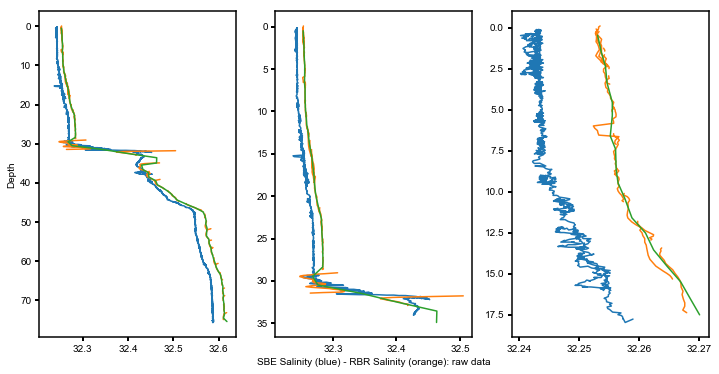

In [1213]:
start_time = '2018-10-11 05:40:00' 
end_time = '2018-10-11 05:44:00'

fig1 = plt.figure(figsize=(12,6))
ax =plt.subplot(1,3,1)
plt.plot(df_sbe['sal00'][start_time:end_time],df_sbe['prDM'][start_time:end_time])
plt.plot(df_r['salinity'][start_time:end_time],df_r['pressure'][start_time:end_time])
plt.plot(df_r_binned['salinity'],df_r_binned['pressure'])
ax.invert_yaxis()
plt.ylabel('Depth')

end_time = '2018-10-11 05:42:00'
ax =plt.subplot(1,3,2)
plt.plot(df_sbe['sal00'][start_time:end_time],df_sbe['prDM'][start_time:end_time])
plt.plot(df_r['salinity'][start_time:end_time],df_r['pressure'][start_time:end_time])
plt.plot(df_r_binned['salinity'][0:35],df_r_binned['pressure'][0:35])
ax.invert_yaxis()
plt.xlabel('SBE Salinity (blue) - RBR Salinity (orange): raw data')

end_time = '2018-10-11 05:41:00'
ax =plt.subplot(1,3,3)
plt.plot(df_sbe['sal00'][start_time:end_time],df_sbe['prDM'][start_time:end_time])
plt.plot(df_r['salinity'][start_time:end_time],df_r['pressure'][start_time:end_time])
plt.plot(df_r_binned['salinity'][0:18],df_r_binned['pressure'][0:18])
ax.invert_yaxis()

##### 1sec averages

Now lets sample to a comparable scale... 1s data will allow a direct comparison (although we usually use 1m/1dbar bins)

No additional qc has been done to the datasets

In [1202]:
df_rsec = df_r.resample('1s').mean()
df_sbesec = df_sbe.resample('1s').mean()

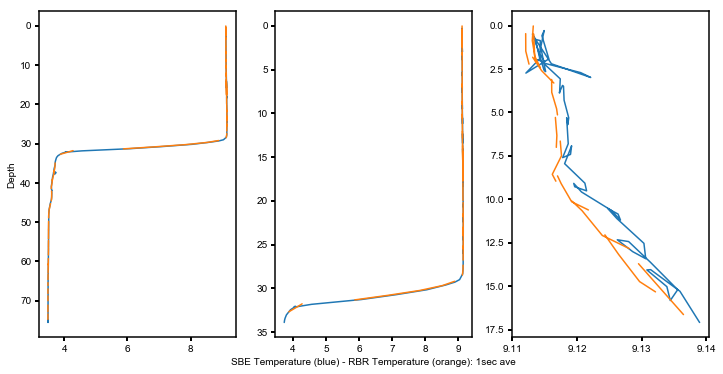

In [1203]:
start_time = '2018-10-11 05:40:00' 
end_time = '2018-10-11 05:44:00'

fig1 = plt.figure(figsize=(12,6))
ax =plt.subplot(1,3,1)
plt.plot(df_sbesec['t090C'][start_time:end_time],df_sbesec['prDM'][start_time:end_time])
plt.plot(df_rsec['temperature'][start_time:end_time],df_rsec['pressure'][start_time:end_time])
ax.invert_yaxis()
plt.ylabel('Depth')

end_time = '2018-10-11 05:42:00'
ax =plt.subplot(1,3,2)
plt.plot(df_sbesec['t090C'][start_time:end_time],df_sbesec['prDM'][start_time:end_time])
plt.plot(df_rsec['temperature'][start_time:end_time],df_rsec['pressure'][start_time:end_time])
ax.invert_yaxis()
plt.xlabel('SBE Temperature (blue) - RBR Temperature (orange): 1sec ave')

end_time = '2018-10-11 05:41:00'
ax =plt.subplot(1,3,3)
plt.plot(df_sbesec['t090C'][start_time:end_time],df_sbesec['prDM'][start_time:end_time])
plt.plot(df_rsec['temperature'][start_time:end_time],df_rsec['pressure'][start_time:end_time])
ax.invert_yaxis()

##### 1sec averages - Difference between SBE-RBR


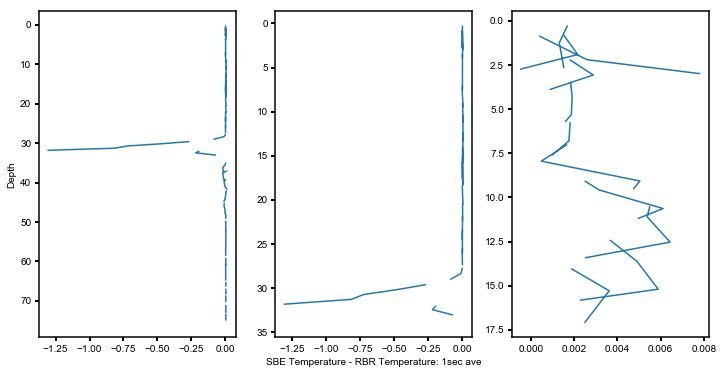

In [1204]:
start_time = '2018-10-11 05:40:00' 
end_time = '2018-10-11 05:44:00'

fig1 = plt.figure(figsize=(12,6))
ax =plt.subplot(1,3,1)
plt.plot(df_sbesec['t090C'][start_time:end_time]-df_rsec['temperature'][start_time:end_time],df_sbesec['prDM'][start_time:end_time])
ax.invert_yaxis()
plt.ylabel('Depth')

end_time = '2018-10-11 05:42:00'
ax =plt.subplot(1,3,2)
plt.plot(df_sbesec['t090C'][start_time:end_time]-df_rsec['temperature'][start_time:end_time],df_sbesec['prDM'][start_time:end_time])
ax.invert_yaxis()
plt.xlabel('SBE Temperature - RBR Temperature: 1sec ave')

end_time = '2018-10-11 05:41:00'
ax =plt.subplot(1,3,3)
plt.plot(df_sbesec['t090C'][start_time:end_time]-df_rsec['temperature'][start_time:end_time],df_sbesec['prDM'][start_time:end_time])
ax.invert_yaxis()

***salinity***

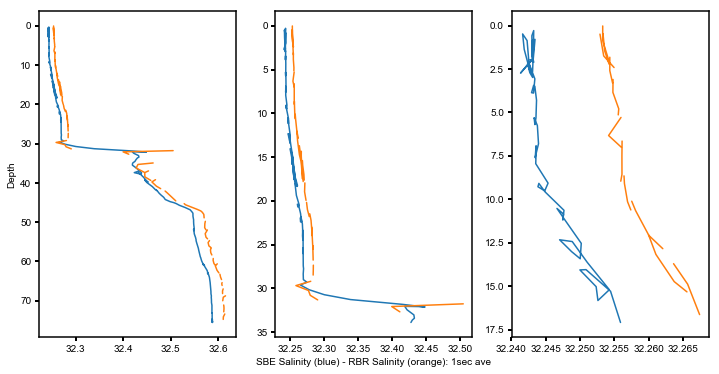

In [1205]:
start_time = '2018-10-11 05:40:00' 
end_time = '2018-10-11 05:44:00'

fig1 = plt.figure(figsize=(12,6))
ax =plt.subplot(1,3,1)
plt.plot(df_sbesec['sal00'][start_time:end_time],df_sbesec['prDM'][start_time:end_time])
plt.plot(df_rsec['salinity'][start_time:end_time],df_rsec['pressure'][start_time:end_time])
ax.invert_yaxis()
plt.ylabel('Depth')

end_time = '2018-10-11 05:42:00'
ax =plt.subplot(1,3,2)
plt.plot(df_sbesec['sal00'][start_time:end_time],df_sbesec['prDM'][start_time:end_time])
plt.plot(df_rsec['salinity'][start_time:end_time],df_rsec['pressure'][start_time:end_time])
ax.invert_yaxis()
plt.xlabel('SBE Salinity (blue) - RBR Salinity (orange): 1sec ave')

end_time = '2018-10-11 05:41:00'
ax =plt.subplot(1,3,3)
plt.plot(df_sbesec['sal00'][start_time:end_time],df_sbesec['prDM'][start_time:end_time])
plt.plot(df_rsec['salinity'][start_time:end_time],df_rsec['pressure'][start_time:end_time])
ax.invert_yaxis()


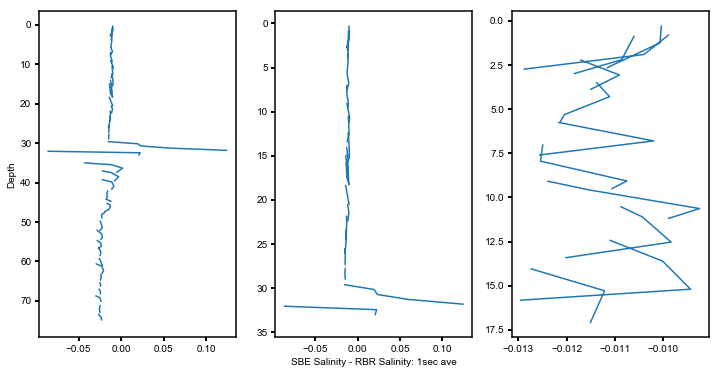

In [1206]:
start_time = '2018-10-11 05:40:00' 
end_time = '2018-10-11 05:44:00'

fig1 = plt.figure(figsize=(12,6))
ax =plt.subplot(1,3,1)
plt.plot(df_sbesec['sal00'][start_time:end_time]-df_rsec['salinity'][start_time:end_time],df_sbesec['prDM'][start_time:end_time])
ax.invert_yaxis()
plt.ylabel('Depth')

end_time = '2018-10-11 05:42:00'
ax =plt.subplot(1,3,2)
plt.plot(df_sbesec['sal00'][start_time:end_time]-df_rsec['salinity'][start_time:end_time],df_sbesec['prDM'][start_time:end_time])
ax.invert_yaxis()
plt.xlabel('SBE Salinity - RBR Salinity: 1sec ave')

end_time = '2018-10-11 05:41:00'
ax =plt.subplot(1,3,3)
plt.plot(df_sbesec['sal00'][start_time:end_time]-df_rsec['salinity'][start_time:end_time],df_sbesec['prDM'][start_time:end_time])
ax.invert_yaxis()

***sigma-t***

In [1207]:
### calculate density (sigma-t) to compare against each other from the 1s data

import seawater

df_sbesec['sigmat00'] = seawater.dens(s=df_sbesec['sal00'],t=df_sbesec['t090C'],p=df_sbesec['prDM']) - 1000.
df_rsec['sigmat'] = seawater.dens(s=df_rsec['salinity'],t=df_rsec['temperature'],p=df_rsec['pressure']) - 1000.


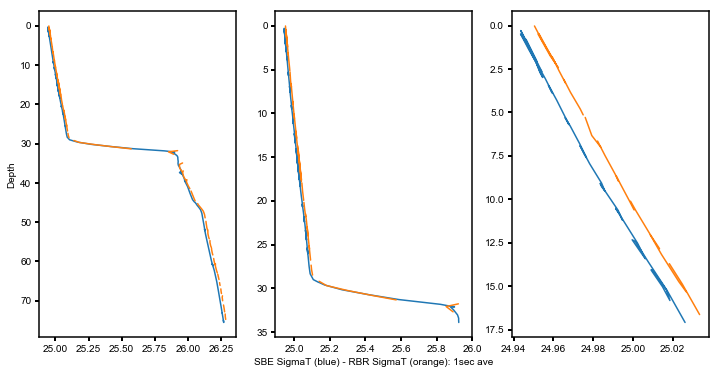

In [1208]:
start_time = '2018-10-11 05:40:00' 
end_time = '2018-10-11 05:44:00'

fig1 = plt.figure(figsize=(12,6))
ax =plt.subplot(1,3,1)
plt.plot(df_sbesec['sigmat00'][start_time:end_time],df_sbesec['prDM'][start_time:end_time])
plt.plot(df_rsec['sigmat'][start_time:end_time],df_rsec['pressure'][start_time:end_time])
ax.invert_yaxis()
plt.ylabel('Depth')

end_time = '2018-10-11 05:42:00'
ax =plt.subplot(1,3,2)
plt.plot(df_sbesec['sigmat00'][start_time:end_time],df_sbesec['prDM'][start_time:end_time])
plt.plot(df_rsec['sigmat'][start_time:end_time],df_rsec['pressure'][start_time:end_time])
ax.invert_yaxis()
plt.xlabel('SBE SigmaT (blue) - RBR SigmaT (orange): 1sec ave')

end_time = '2018-10-11 05:41:00'
ax =plt.subplot(1,3,3)
plt.plot(df_sbesec['sigmat00'][start_time:end_time],df_sbesec['prDM'][start_time:end_time])
plt.plot(df_rsec['sigmat'][start_time:end_time],df_rsec['pressure'][start_time:end_time])
ax.invert_yaxis()


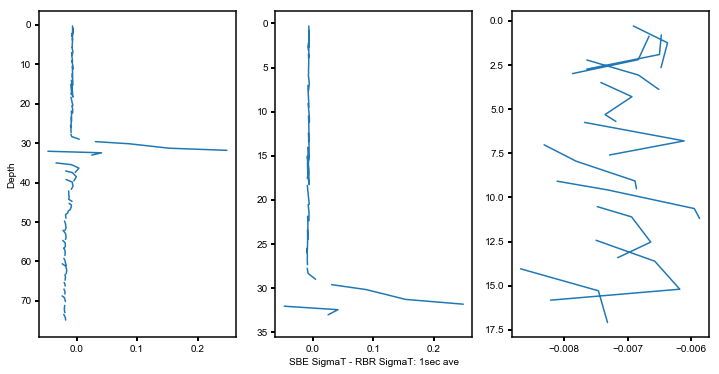

In [1209]:
start_time = '2018-10-11 05:40:00' 
end_time = '2018-10-11 05:44:00'

fig1 = plt.figure(figsize=(12,6))
ax =plt.subplot(1,3,1)
plt.plot(df_sbesec['sigmat00'][start_time:end_time]-df_rsec['sigmat'][start_time:end_time],df_sbesec['prDM'][start_time:end_time])
ax.invert_yaxis()
plt.ylabel('Depth')

end_time = '2018-10-11 05:42:00'
ax =plt.subplot(1,3,2)
plt.plot(df_sbesec['sigmat00'][start_time:end_time]-df_rsec['sigmat'][start_time:end_time],df_sbesec['prDM'][start_time:end_time])
ax.invert_yaxis()
plt.xlabel('SBE SigmaT - RBR SigmaT: 1sec ave')

end_time = '2018-10-11 05:41:00'
ax =plt.subplot(1,3,3)
plt.plot(df_sbesec['sigmat00'][start_time:end_time]-df_rsec['sigmat'][start_time:end_time],df_sbesec['prDM'][start_time:end_time])
ax.invert_yaxis()

### readin processed seabird data

In [1210]:
colnames = ['c0mS/cm','c1mS/cm','flECO-AFL','sbeox0V','t090C','t190C','timeS','prDM','sbeox1V','par',
            'turbWETntu0','sal00','sal11','sigma-t00','sigma-t11','sbeox0ML/L','sbox0Mm/Kg','sbeox0PS',
            'sbeox1ML/L','sbox1Mm/Kg','sbeox1PS','nbin','flag']
df_sbe_1m = pd.read_csv('/Users/bell/ecoraid/2018/CTDcasts/AQ1801/rawconverted/ctd025.cnv',skiprows=353,names=colnames,delimiter='\s+')

#start_time
df_sbe_1m['DateTime']=[datetime.datetime.strptime('Oct 11 2018  05:39:51','%b %d %Y %H:%M:%S')+datetime.timedelta(seconds=y['timeS']) for x,y in df_sbe_1m.iterrows()]
df_sbe_1m.set_index(df_sbe_1m['prDM'],inplace=True)


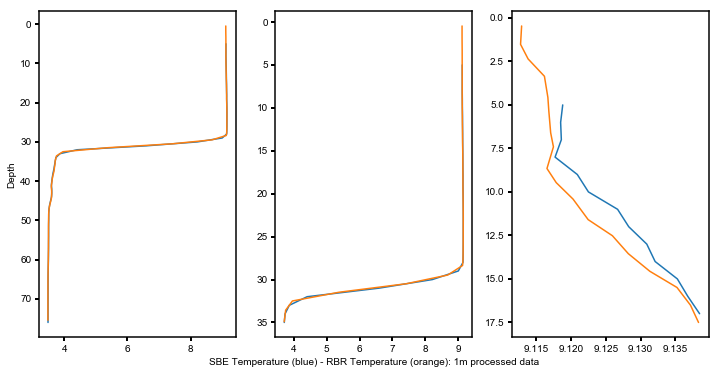

In [1216]:
fig1 = plt.figure(figsize=(12,6))
ax =plt.subplot(1,3,1)
plt.plot(df_sbe_1m['t090C'],df_sbe_1m.index)
plt.plot(df_r_binned['temperature'],df_r_binned['pressure'])
ax.invert_yaxis()
plt.ylabel('Depth')

ax =plt.subplot(1,3,2)
plt.plot(df_sbe_1m[0:35]['t090C'],df_sbe_1m[0:35].index)
plt.plot(df_r_binned['temperature'][0:35],df_r_binned['pressure'][0:35])
ax.invert_yaxis()
plt.xlabel('SBE Temperature (blue) - RBR Temperature (orange): 1m processed data')

ax =plt.subplot(1,3,3)
plt.plot(df_sbe_1m[0:17]['t090C'],df_sbe_1m[0:17].index)
plt.plot(df_r_binned['temperature'][0:18],df_r_binned['pressure'][0:18])
ax.invert_yaxis()

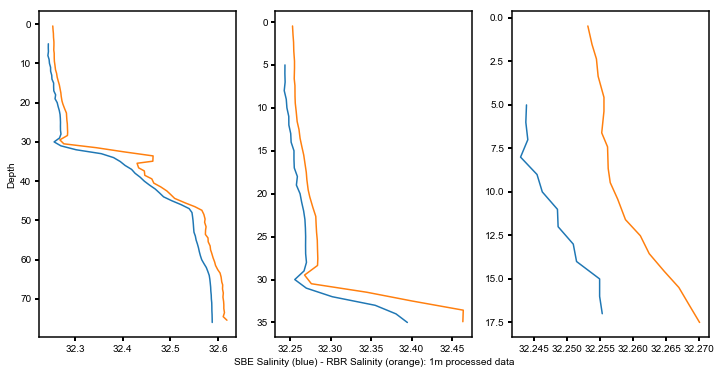

In [1215]:
fig1 = plt.figure(figsize=(12,6))
ax =plt.subplot(1,3,1)
plt.plot(df_sbe_1m['sal00'],df_sbe_1m.index)
plt.plot(df_r_binned['salinity'],df_r_binned['pressure'])
ax.invert_yaxis()
plt.ylabel('Depth')

ax =plt.subplot(1,3,2)
plt.plot(df_sbe_1m[0:35]['sal00'],df_sbe_1m[0:35].index)
plt.plot(df_r_binned['salinity'][0:35],df_r_binned['pressure'][0:35])
ax.invert_yaxis()
plt.xlabel('SBE Salinity (blue) - RBR Salinity (orange): 1m processed data')

ax =plt.subplot(1,3,3)
plt.plot(df_sbe_1m[0:17]['sal00'],df_sbe_1m[0:17].index)
plt.plot(df_r_binned['salinity'][0:18],df_r_binned['pressure'][0:18])
ax.invert_yaxis()